<a href="https://colab.research.google.com/github/Potisimus/ML_NoteBooks/blob/master/Toxic_Comment_with_BERT_Mohammad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
# Load Data
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/Kaggle/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# Length of Data
print('There are {:,} training examples.'.format(len(train)))

There are 159,571 training examples.


In [ ]:
# Display some of the comments labeled as containing an attack
import textwrap
import random

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

# Filter to just the "insult" comments.
insults = train.loc[train.insult == 1]['comment_text']
comments = train.loc[train.insult == 1]['comment_text']

# Randomly choose some examples.
for i in range(5):
    j = random.choice(insults.index)
    
    print('')
    print(wrapper.fill(insults[j]))
    print('')



Screw you! A devout Leftist deleted my fact based contribution and you defend
hym/hyr/shyt? We're on to, we have been since the beginning, we have finally
decided to fight back. Soon OUR voices will be heard and your kind will rue the
day you screwed with us and our nation.    Bold text


Yamla_likes_to_fuck_babies_up_the_ass_wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww
wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww
wwwwwwwwww   Willy on Wheels is the ultimate vandal. JLaTondre should fuck off
wikipedia and get raped in the eye!


You Are a fuck head I'm not a vandal so suck cock ass master.  We'll talk after
your done with your Mom.


hey bitch im trying to edit this page and u deleted it. u son of a bitch better
put it back or im going to find u and kick your FAT ASS!


Hey Rancie you Prick, go suck a great big uncircumcized one!    - Tony
Greenstein



In [ ]:
# Class Distribution

# These are the six possible labels.
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Select just the labels (not the text), and for every row, check whether any
# of the labels are "1".
has_labels = train[label_cols].any(axis=1)

# Add a new column indicating which samples have no toxic labels.
train['none'] = 1 - has_labels

# Add the 'none' column to our list of label names.
label_cols.append('none')

In [ ]:
# Tally up each label separately.
label_counts = train[label_cols].sum(axis=0)

print(label_counts)

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
none             143346
dtype: int64


In [ ]:
# What % are toxic?
print('{:.1%} of the comments are safe.'.format(label_counts['none'] / len(train)))

89.8% of the comments are safe.


Text(0, 0.5, '# of Training Samples')

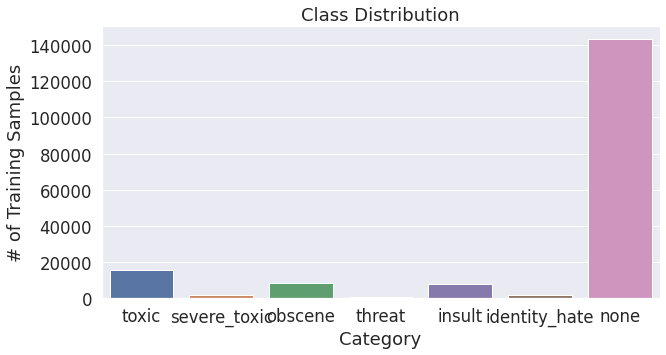

In [ ]:
# Samples in each category
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the number of tokens of each length.
sns.barplot(x=label_cols, y=label_counts)
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('# of Training Samples')


In [ ]:
train.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [ ]:
#Based on the above, if we just predicted "not toxic" for every single training sample, we would get ~90% accuracy on the training set! 
#So we'll have to be careful in how we interpret our accuracy on this task to make sure we're actually doing better than this.

In [ ]:
# Tokenization and Truncation
# Exploring Lengths of our text samples in dataset
# Loading BERT Tokenizer

from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
import numpy as np
import logging
 
# we'll adjust the logging settings to suppress those warnings and keep the output
# cell cleaner.
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Record the length of each sequence (in terms of BERT tokens).
lengths = []

print('Tokenizing comments...')

# For every sentence...
for index, row in train.iterrows():
    
    # Report progress.
    if ((len(lengths) % 20000) == 0):
        print('  Tokenized {:,} comments.'.format(len(lengths)))
    
    
    encoded_sent = tokenizer.encode(
                        row['comment_text'],     
                        add_special_tokens = True, 
                   )
    
    # Record the non-truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')

Tokenizing comments...
  Tokenized 0 comments.
  Tokenized 20,000 comments.
  Tokenized 40,000 comments.
  Tokenized 60,000 comments.
  Tokenized 80,000 comments.
  Tokenized 100,000 comments.
  Tokenized 120,000 comments.
  Tokenized 140,000 comments.
DONE.


In [ ]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(int(np.median(lengths))))

   Min length: 4 tokens
   Max length: 4,950 tokens
Median length: 52 tokens


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


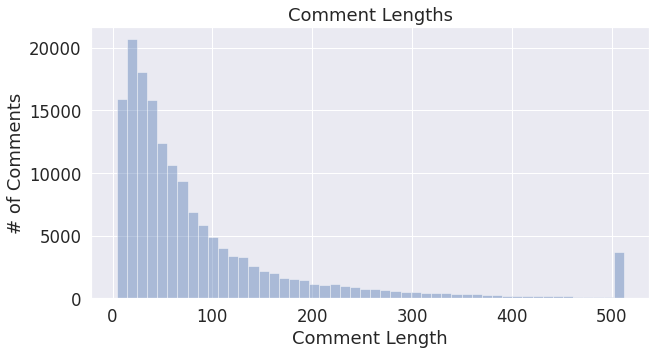

In [ ]:
# Let's visualise the comments length
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any comment lengths greater than 512.
trunc_lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(trunc_lengths, kde=False, rug=False)

plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('# of Comments')

plt.show()

In [ ]:
#Clearly the majority of the comments are relatively short. Let's count up 
# how many comments would be truncated based on different choices of max_len

# Cast the list to a numpy array so we can use some numpy features.
lengths = np.asarray(lengths)

# Get the total number of comments.
num_comments = len(lengths)

# Check the following lengths:
max_lens = [128, 256, 300, 400, 512]

print('How many comments will be truncated?\n')

# For each choice...
for max_len in max_lens:

    # Calculate how many comments will be truncacted.
    num_over = np.sum(lengths > max_len)

    # And as a percentage.
    prcnt_over = float(num_over) / float(num_comments)

    print('max_len = {:}  -->  {:>7,} of {:>7,}  ({:>5.1%})  ' \
          'will be truncated '.format(
              max_len, num_over, num_comments, prcnt_over
          ))

How many comments will be truncated?

max_len = 128  -->   30,790 of 159,571  (19.3%)  will be truncated 
max_len = 256  -->   11,063 of 159,571  ( 6.9%)  will be truncated 
max_len = 300  -->    8,446 of 159,571  ( 5.3%)  will be truncated 
max_len = 400  -->    5,160 of 159,571  ( 3.2%)  will be truncated 
max_len = 512  -->    3,523 of 159,571  ( 2.2%)  will be truncated 


In [ ]:
# Set our sequence length to pad or truncate all of our samples to.
max_len = 128

In [ ]:
import torch
import time

input_ids = []
attn_masks = []
labels = []

t0 = time.time()

# ======== Encoding ========

print('Encoding {:,} training examples...'.format(len(train)))

# For every training example...
for (index, row) in train.iterrows():

    # Report progress.
    if ((len(input_ids) % 15000) == 0):
        print('  Encoded {:,} comments.'.format(len(input_ids)))

    # Convert sentence pairs to input IDs, with attention masks.
    encoded_dict = tokenizer.encode_plus(row['comment_text'],  
                                        max_length=max_len,    
                                        pad_to_max_length=True,
                                        truncation=True, 
                                        return_tensors='pt')   

    # Add this example to our lists.
    input_ids.append(encoded_dict['input_ids'])
    attn_masks.append(encoded_dict['attention_mask'])
    
print('\nDONE. {:,} examples.'.format(len(input_ids)))

# ======== List of Examples --> Tensor ========

# Convert each Python list of Tensors into a 2D Tensor matrix.
input_ids = torch.cat(input_ids, dim=0)
attn_masks = torch.cat(attn_masks, dim=0)

# ======== Prepare Labels ========

# Select the label columns for all examples.
labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# The labels are either 0 or 1. Despite this, we need to cast the values to

labels = labels.to_numpy().astype(float)

# Cast the labels list to a 2D Tensor.
labels = torch.tensor(labels)

# ======== Summary ========

print('\nData structure shapes:')
print('   input_ids:  {:}'.format(str(input_ids.shape)))
print('  attn_masks:  {:}'.format(str(attn_masks.shape)))
print('      labels:  {:}'.format(str(labels.shape)))

print('\nEncoding took {:.0f} seconds'.format(time.time() - t0))

Encoding 159,571 training examples...
  Encoded 0 comments.


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  Encoded 15,000 comments.
  Encoded 30,000 comments.
  Encoded 45,000 comments.
  Encoded 60,000 comments.
  Encoded 75,000 comments.
  Encoded 90,000 comments.
  Encoded 105,000 comments.
  Encoded 120,000 comments.
  Encoded 135,000 comments.
  Encoded 150,000 comments.

DONE. 159,571 examples.

Data structure shapes:
   input_ids:  torch.Size([159571, 128])
  attn_masks:  torch.Size([159571, 128])
      labels:  torch.Size([159571, 6])

Encoding took 276 seconds


In [ ]:
# Dividing the train set to train and validation set
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attn_masks, labels)

# Create a 90-10 train-validation split. Calculate the number of samples to 
# include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
# Using Colab GPU for Training
import torch
torch.cuda.empty_cache()
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
# BERT Model for Multilabel Classification
from torch import nn
from torch.nn import BCEWithLogitsLoss
from transformers import BertPreTrainedModel, BertModel

class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    '''
    This custom class closely resembles BertForSequenceClassification, which
    supports multiclass classification, but not multi-label.
    This modified version supports data points with multiple labels.
    '''

    def __init__(self, config):
        '''
        Class initializer, called when we create a new instance of this class.
        '''

        # Call the init function of the parent class (BertPreTrainedModel)        
        super().__init__(config)
       
        # Store the number of labels.
        self.num_labels = config.num_labels
        
        # Create a `BertModel`--this implements all of BERT except for the final
        # task-specific output layer (which is what we'll do here in `forward`). 
        self.bert = BertModel(config)

        # Setup dropout object (note: I'm not familiar enough to speak to this).
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize model weights (inherited function).
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
 

      
        outputs = self.bert(
            input_ids,                      
            attention_mask=attention_mask,  
            token_type_ids=token_type_ids,  
            position_ids=position_ids,      
            head_mask=head_mask,            
            inputs_embeds=inputs_embeds,    
                                            
            output_attentions=output_attentions, 
                                                 
            output_hidden_states=output_hidden_states, 
                                                       
                                                       
        )

        
        final_embeddings = outputs[0]

        
        activated_cls = outputs[1]

        logits = self.classifier(activated_cls)
        
        # ===================
        #   Training Mode
        # ===================

        if labels is not None:
          
          loss_fct = BCEWithLogitsLoss()

            # Call the loss function, giving it the `logits` and the correct
            # `labels`.
          loss = loss_fct(logits.view(-1, self.num_labels), # The logits
                            labels.view(-1, self.num_labels)) # The labels

            
          return ((loss, logits) + outputs[2:])

        
        else:
            return ((logits,) + outputs[2:])

In [ ]:
# Initialize BERT Model with Pre-Trained Weights
from transformers import AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForMultiLabelSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 6,    
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

print ("Model loaded.")


In [ ]:
# Batch Size and DataLoaders

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Specify our batch size.
batch_size = 16

# Create the DataLoaders for our training sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # the authors recommend the following choices of learning rates: 5e-5, 3e-5, 2e-5 (We'll use 2e-5)
                  eps = 1e-8 
                )


In [ ]:
#  Epochs & Learning Rate Scheduler
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (BERT authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Some Helper functions
# Helper function for formatting elapsed times.

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))  


In [ ]:
# Helper function to automatically pick a reasonable interval for printing out a progress update during training.

def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    '''
    
    exact_interval = total_iters / num_desired_updates

    
    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [ ]:
# Submissions for the Toxic Comments Challenge are evaluated "on the mean column-wise ROC AUC"
from sklearn.metrics import roc_auc_score

# A quick example...
true_labels = [0,1,0,0,1]
pred_labels = [0,1,0,0,0]

score = roc_auc_score(true_labels, pred_labels, average='macro')

print('Example ROC AUC score:', score)

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader), 
                num_desired_updates = 10
            )

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update.
        if (step % update_interval) == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
 
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_loss = 0

    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():   
   

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Measure validation accuracy...

    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Calculate the validation accuracy.
    val_accuracy = roc_auc_score(flat_true_labels, flat_predictions, average='macro')

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch   900  of  8,976.    Elapsed: 0:02:10.
  Batch 1,800  of  8,976.    Elapsed: 0:04:21.
  Batch 2,700  of  8,976.    Elapsed: 0:06:31.
  Batch 3,600  of  8,976.    Elapsed: 0:08:41.
  Batch 4,500  of  8,976.    Elapsed: 0:10:50.
  Batch 5,400  of  8,976.    Elapsed: 0:13:00.
  Batch 6,300  of  8,976.    Elapsed: 0:15:10.
  Batch 7,200  of  8,976.    Elapsed: 0:17:20.
  Batch 8,100  of  8,976.    Elapsed: 0:19:30.

  Average training loss: 0.05
  Training epcoh took: 0:21:37

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.04
  Validation took: 0:00:37

======== Epoch 2 / 3 ========
Training...
  Batch   900  of  8,976.    Elapsed: 0:02:10.
  Batch 1,800  of  8,976.    Elapsed: 0:04:20.
  Batch 2,700  of  8,976.    Elapsed: 0:06:30.
  Batch 3,600  of  8,976.    Elapsed: 0:08:40.
  Batch 4,500  of  8,976.    Elapsed: 0:10:50.
  Batch 5,400  of  8,976.    Elapsed: 0:13:00.
  Batch 6,300  of  8,976.    Elapsed: 0:15:11.
  Batch 7

In [ ]:
# Training Results
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.05,0.04,0.99,0:21:37,0:00:37
2,0.03,0.04,0.99,0:21:37,0:00:37
3,0.02,0.04,0.99,0:21:25,0:00:37


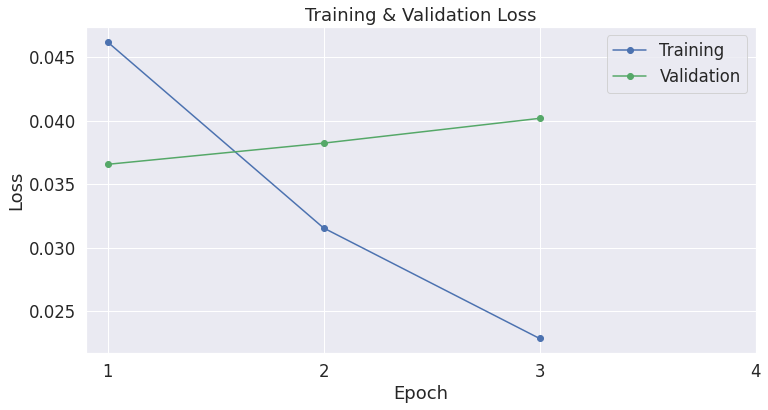

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Preoaring the Test Set
# Load the test set files.
test = pd.read_csv('/content/drive/MyDrive/Kaggle/jigsaw-toxic-comment-classification-challenge/test.csv/test.csv')
test_labels = pd.read_csv('/content/drive/MyDrive/Kaggle/jigsaw-toxic-comment-classification-challenge/test_labels.csv/test_labels.csv')

# The test set contains 153,164 samples, but only includes labels for 63,978 of them

print('There are {:,} total test examples.'.format(len(test)))

# The unlabeled test samples are indicated by all of the label values being
# "-1" for that sample.

# Select only the labeled test samples.
test = test[test_labels.toxic != - 1]
test_labels = test_labels.loc[test_labels.toxic != -1]

print('There are {:,} labeled test examples.'.format(len(test)))

There are 153,164 total test examples.
There are 63,978 labeled test examples.


In [ ]:
# Tokenize and encode the test data

import torch

input_ids = []
attn_masks = []
labels = []

# ======== Encoding ========

print('Encoding all {:,} test samples...'.format(len(test)))

# For every test sample...
for (index, row) in test.iterrows():

    # Report progress.
    if ((len(input_ids) % 5000) == 0):
        print('  Tokenized {:,} comments.'.format(len(input_ids)))

    # Convert sentence pairs to input IDs, with attention masks.
    encoded_dict = tokenizer.encode_plus(row['comment_text'],  # The text to encode.
                                        max_length=max_len,    # Pad or truncate to this lenght.
                                        pad_to_max_length=True,
                                        truncation=True, 
                                        return_tensors='pt')   # Return objects as PyTorch tensors.

    # Add this example to our lists.
    input_ids.append(encoded_dict['input_ids'])
    attn_masks.append(encoded_dict['attention_mask'])
    
print('\nDONE. {:,} examples.'.format(len(input_ids)))

# ======== List of Examples --> Tensor ========

# Convert each Python list of Tensors into a 2D Tensor matrix.
input_ids = torch.cat(input_ids, dim=0)
attn_masks = torch.cat(attn_masks, dim=0)

Encoding all 63,978 test samples...
  Tokenized 0 comments.


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  Tokenized 5,000 comments.
  Tokenized 10,000 comments.
  Tokenized 15,000 comments.
  Tokenized 20,000 comments.
  Tokenized 25,000 comments.
  Tokenized 30,000 comments.
  Tokenized 35,000 comments.
  Tokenized 40,000 comments.
  Tokenized 45,000 comments.
  Tokenized 50,000 comments.
  Tokenized 55,000 comments.
  Tokenized 60,000 comments.

DONE. 63,978 examples.


In [ ]:

# ======== Prepare Labels ========

# Remove the 'id' column.
#test_labels = test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
del test_labels['id']

# The labels are either 0 or 1. Despite this, we need to cast the values to
# floats--otherwise our loss function will throw an error.

labels = test_labels.to_numpy().astype(float)

# Cast the labels list to a 2D Tensor.
labels = torch.tensor(labels)

# ======== Summary ========

print('\nData structure shapes:')
print('   input_ids:  {:}'.format(str(input_ids.shape)))
print('  attn_masks:  {:}'.format(str(attn_masks.shape)))
print('      labels:  {:}'.format(str(labels.shape)))


Data structure shapes:
   input_ids:  torch.Size([63978, 128])
  attn_masks:  torch.Size([63978, 128])
      labels:  torch.Size([63978, 6])


In [ ]:
# Create a DataLoader to batch our test samples for us.

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids, attn_masks, labels)

# Specify our batch size.
batch_size = 16

# Create the DataLoader, which will select batches for us. For testing, the
# order we evaluate the samples in doesn't matter, so we'll just use the 
# "SequentialSampler" to read them in order.
test_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = SequentialSampler(test_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

In [ ]:
# Evaluate on Test set

import time

# Prediction on test set

# Put model in evaluation mode
model.eval()

t0 = time.time()

# Tracking variables 
predictions , true_labels = [], []

print('Evaluating on {:,} test set batches...'.format(len(test_dataloader)))

# Predict 
for batch in test_dataloader:
    
    # Report progress.
    if ((len(predictions) % 500) == 0):
        print('  Batch {:>5,}  of  {:>5,}.'.format(len(predictions), len(test_dataloader)))

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store the compute graph, saving memory 
    # and speeding up prediction
    with torch.no_grad():
        
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

print('Evaluation took {:.0f} seconds.'.format(time.time() - t0))

Evaluating on 3,999 test set batches...
  Batch     0  of  3,999.
  Batch   500  of  3,999.
  Batch 1,000  of  3,999.
  Batch 1,500  of  3,999.
  Batch 2,000  of  3,999.
  Batch 2,500  of  3,999.
  Batch 3,000  of  3,999.
  Batch 3,500  of  3,999.
    DONE.
Evaluation took 148 seconds.


In [ ]:
# We collected the predictions in batches, so now we just need to recombine them.
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
# Score Results
# Most samples don't contain anything toxic, so let's find one that actually does.

for test_i in range(0, len(test)):

    # Break if it has at least one label set.
    if np.any(flat_true_labels[test_i, :]):
        break

print('Test sample: {:,}\n'.format(test_i))

Test sample: 8



In [ ]:
# Now we can look at the model's predictions vs. the correct labels for this test sample.
# Print out model predictions vs. correct values for this test sample.
# Since the labels were trained as either 0 or 1, 
# using a threshold of 0.5 seems like a reasonable first choice.

print('           Type   Output   Truth')
print('           ----   ------   -----')

for label_i in range(0, 6):
    print('{:>15}   {:>5.2f}      {:}'.format(
        label_cols[label_i], # Label name
        flat_predictions[test_i, label_i], # Model's prediction
        int(flat_true_labels[test_i, label_i]))) # Correct label

           Type   Output   Truth
           ----   ------   -----
          toxic    4.22      1
   severe_toxic   -3.85      0
        obscene   -2.97      0
         threat   -3.52      0
         insult   -1.48      0
  identity_hate    1.13      0


In [ ]:
# ROC AUC  (Receiver Operating Characteristic, Area Under the Curve) 

# Calcualte the ROC AUC score for our model's predictions.
score = roc_auc_score(flat_true_labels, flat_predictions, average='macro')

print('ROC AUC: {:.4f}'.format(score))

ROC AUC: 0.9833


In [ ]:
# Saving Our Trained ModelAS
score

0.9832655270021754

In [ ]:
# Source
1. https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/